In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.image as mpimg

In [2]:
health_data_preprocessed = pd.read_csv('health_data_preprocessed.csv')

In [3]:
display(health_data_preprocessed)

,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Gluco_Record_Prior_Ntm,Gluco_Record_During_Rx,...,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks,Ntm_Speciality_Restructured
0,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,N,N,...,N,N,N,N,N,N,N,N,0,GENERAL PRACTITIONER
1,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,N,N,...,N,N,N,N,N,N,N,N,0,GENERAL PRACTITIONER
2,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,N,Y,...,N,N,N,N,N,N,N,N,1,GENERAL PRACTITIONER
3,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,Y,Y,...,N,N,N,N,N,N,N,N,1,GENERAL PRACTITIONER
4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,N,N,...,N,N,N,N,N,N,N,N,2,GENERAL PRACTITIONER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3197,Persistent,Female,Caucasian,Not Hispanic,South,>75,GENERAL PRACTITIONER,Others,N,N,...,N,Y,N,N,N,N,N,N,1,GENERAL PRACTITIONER
3198,Persistent,Female,Caucasian,Not Hispanic,South,>75,Unknown,Others,N,N,...,N,N,N,N,N,N,N,N,0,Unknown
3199,Persistent,Female,Caucasian,Not Hispanic,South,>75,ENDOCRINOLOGY,Specialist,N,N,...,N,Y,N,N,N,N,N,N,1,ENDOCRINOLOGY
3200,Non-Persistent,Female,Caucasian,Not Hispanic,South,55-65,Unknown,Others,N,N,...,N,N,N,N,N,N,N,N,0,Unknown


# 3. Model Building

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

import joblib

## Transforming Data - Imputation/One-Hot-Encoding

In [5]:
# Identifying categorical columns that need to be encoded
categorical_columns = health_data_preprocessed.select_dtypes(include=['object']).columns.drop('Persistency_Flag')
numerical_columns = health_data_preprocessed.select_dtypes(exclude=['object']).columns

# Target variable encoding
health_data_preprocessed['Persistency_Flag'] = health_data_preprocessed['Persistency_Flag'].map({'Persistent': 1, 'Non-Persistent': 0})

# Define the transformer for categorical variables
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers into a ColumnTransformer
transform = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_columns),
        ('num', 'passthrough', numerical_columns)
    ])

# Splitting the data into features and target variable
X = health_data_preprocessed.drop('Persistency_Flag', axis=1)
y = health_data_preprocessed['Persistency_Flag']

# Preprocess the data
transform.fit(X)  # Fit the preprocessor on the entire dataset (if necessary, for example, to fit scalers or imputers)
X_transformed = transform.transform(X)  # Transform the dataset

# Split the preprocessed/transformed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y, test_size=0.2, random_state=42)



## Logistic Regression

In [6]:
# Parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet']
}

# Logistic Regression Pipeline
logistic_regression = LogisticRegression(max_iter=10000, random_state=42, solver='saga')  # solver adjusted for use of all penalties


# Grid Search for Logistic Regression
grid_search_lr = GridSearchCV(logistic_regression, param_grid=param_grid_lr, cv=5, scoring='accuracy', return_train_score=True)
grid_search_lr.fit(X_train, y_train)


/Users/Yusuf/PycharmProjects/Venv1/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/Yusuf/PycharmProjects/Venv1/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Yusuf/PycharmProjects/Venv1/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1101, in fit
    raise ValueError(
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn(some_fits_failed_message, FitFailedWa

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=10000, random_state=42,
                                          solver='saga'),
             param_grid={'C': [0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             return_train_score=True, scoring='accuracy')

Best Hyperparameters: {'C': 0.1, 'penalty': 'l2'}
Best Training Accuracy: 0.8243846083455344
Best Validation Accuracy: 0.8074904057017545
Best Test Accuracy (uses best Params): 0.8408736349453978

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87       390
           1       0.84      0.74      0.78       251

    accuracy                           0.84       641
   macro avg       0.84      0.82      0.83       641
weighted avg       0.84      0.84      0.84       641

Logistic Regression Accuracy: 0.8408736349453978
Logistic Regression Precision: 0.8371040723981901
Logistic Regression Recall: 0.7370517928286853
Logistic Regression F1 Score: 0.7838983050847458


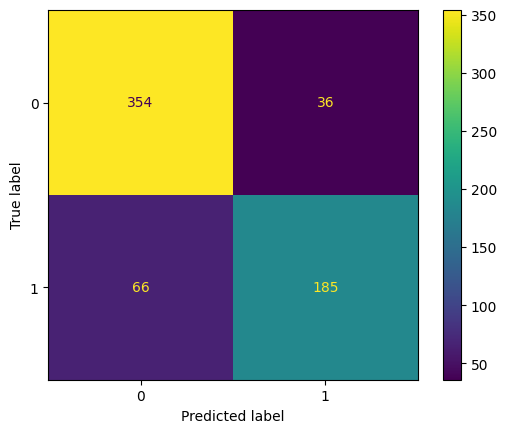

In [7]:
print('Best Hyperparameters:', grid_search_lr.best_params_)
print('Best Training Accuracy:', grid_search_lr.cv_results_['mean_train_score'][grid_search_lr.best_index_])
print('Best Validation Accuracy:', grid_search_lr.best_score_)
print('Best Test Accuracy (uses best Params):', grid_search_lr.score(X_test, y_test))

y_pred_lr = grid_search_lr.predict(X_test) # Automatically uses the best parameters

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Print classification report and overall statistics
print('\nClassification Report:\n', classification_report(y_test, y_pred_lr))
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression Precision:", precision_score(y_test, y_pred_lr))
print("Logistic Regression Recall:", recall_score(y_test, y_pred_lr))
print("Logistic Regression F1 Score:", f1_score(y_test, y_pred_lr))

Logistic Regression ROC-AUC Score: 0.9014914700173664


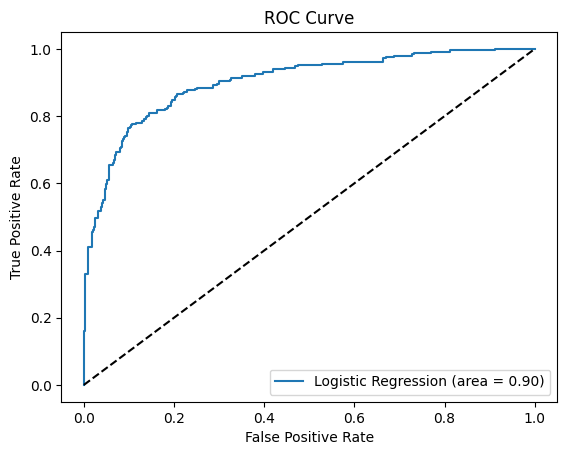

In [8]:
y_proba_lr = grid_search_lr.predict_proba(X_test)[:, 1]  # get the probability estimates for the positive class

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_proba_lr)
print("Logistic Regression ROC-AUC Score:", roc_auc)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_lr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


## Random Forest

Model Build

In [9]:

# Parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Random Forest Pipeline
random_forest = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(random_forest, param_grid=param_grid_rf, cv=5, scoring='accuracy', return_train_score=True)

grid_search_rf.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             return_train_score=True, scoring='accuracy')

Model Evaluation

Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best Training Accuracy: 0.9445525065580771
Best Validation Accuracy: 0.8125685307017545
Best Test Accuracy (Auto uses best Params): 0.8252730109204368

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86       390
           1       0.82      0.71      0.76       251

    accuracy                           0.83       641
   macro avg       0.82      0.80      0.81       641
weighted avg       0.82      0.83      0.82       641

Random Forest Accuracy: 0.8252730109204368
Random Forest Precision: 0.8202764976958525
Random Forest Recall: 0.7091633466135459
Random Forest F1 Score: 0.7606837606837608


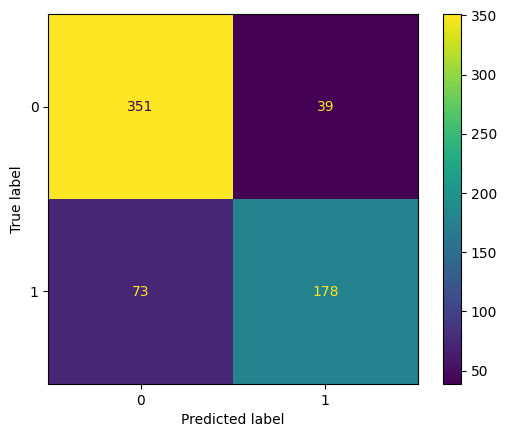

In [10]:
print('Best Hyperparameters:', grid_search_rf.best_params_)
print('Best Training Accuracy:', grid_search_rf.cv_results_['mean_train_score'][grid_search_rf.best_index_])
print('Best Validation Accuracy:', grid_search_rf.best_score_)
print('Best Test Accuracy (Auto uses best Params):', grid_search_rf.score(X_test, y_test))

y_pred_rf = grid_search_rf.predict(X_test) # Automatically uses the best parameters

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Print classification report
print('\nClassification Report:\n', classification_report(y_test, y_pred_rf))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Precision:", precision_score(y_test, y_pred_rf))
print("Random Forest Recall:", recall_score(y_test, y_pred_rf))
print("Random Forest F1 Score:", f1_score(y_test, y_pred_rf))

Random Forest ROC-AUC Score: 0.8942384308918174


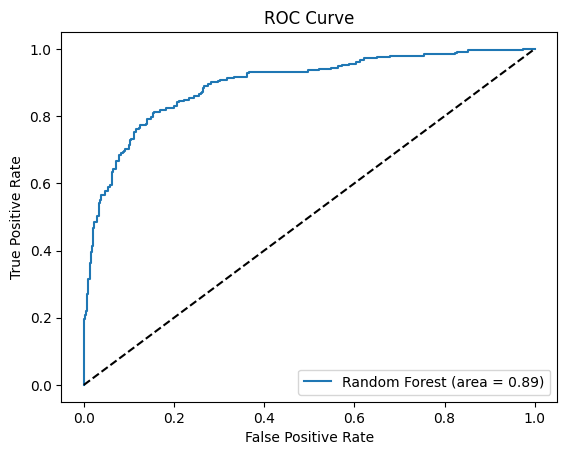

In [11]:
y_proba_rf = grid_search_rf.predict_proba(X_test)[:, 1]  # get the probability estimates for the positive class

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_proba_rf)
print("Random Forest ROC-AUC Score:", roc_auc)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## XGBoost

In [12]:

# Parameter grid for XGBoost
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10]
}

# XGBoost Pipeline
xgboost = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Grid Search for XGBoost
grid_search_xgb = GridSearchCV(xgboost, param_grid=param_grid_xgb, cv=5, scoring='accuracy', return_train_score=True)
grid_search_xgb.fit(X_train, y_train)

# Use randomsearch - more efficient or bayesian search


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 6, 10], 'n_estimators': [100, 200]},
             return_train_score=True, scoring='accuracy')

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best Training Accuracy: 0.8670443756863104
Best Validation Accuracy: 0.8117819505360624
Best Test Accuracy (uses best Params): 0.8471138845553822

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.92      0.88       390
           1       0.85      0.74      0.79       251

    accuracy                           0.85       641
   macro avg       0.85      0.83      0.84       641
weighted avg       0.85      0.85      0.84       641

XGBoost Accuracy: 0.8471138845553822
XGBoost Precision: 0.8493150684931506
XGBoost Recall: 0.7410358565737052
XGBoost F1 Score: 0.7914893617021276


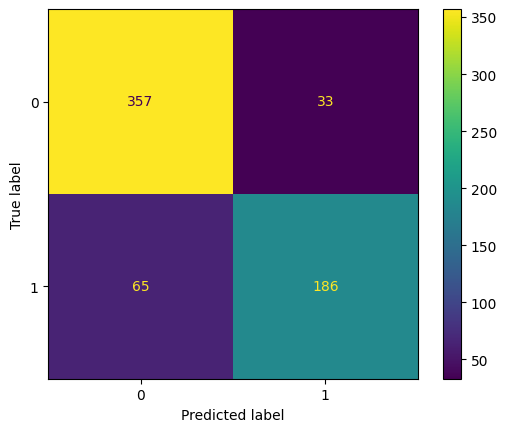

In [13]:
print('Best Hyperparameters:', grid_search_xgb.best_params_)
print('Best Training Accuracy:', grid_search_xgb.cv_results_['mean_train_score'][grid_search_xgb.best_index_])
print('Best Validation Accuracy:', grid_search_xgb.best_score_)
print('Best Test Accuracy (uses best Params):', grid_search_xgb.score(X_test, y_test))

y_pred_xgb = grid_search_xgb.predict(X_test) # Automatically uses the best parameters

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Print classification report
print('\nClassification Report:\n', classification_report(y_test, y_pred_xgb))
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost Precision:", precision_score(y_test, y_pred_xgb))
print("XGBoost Recall:", recall_score(y_test, y_pred_xgb))
print("XGBoost F1 Score:", f1_score(y_test, y_pred_xgb))

XGBoost ROC-AUC Score: 0.9066196751455717


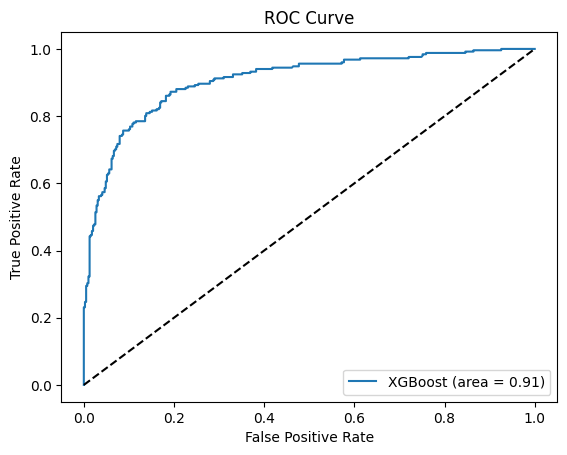

In [14]:
y_proba_xgb = grid_search_xgb.predict_proba(X_test)[:, 1]  # get the probability estimates for the positive class

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_proba_xgb)
print("XGBoost ROC-AUC Score:", roc_auc)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_xgb)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Saving Model/Preprocesser

In [15]:
import joblib

# Save the preprocessor to a file
joblib.dump(transform, 'transformer.pkl')

# Save the best estimator for logistic regression  
joblib.dump(grid_search_lr.best_estimator_, 'logistic_regression_model.pkl')

['logistic_regression_model.pkl']

# Future Work

Feature Importances for Each Model


In [16]:
# Accessing the best estimator from GridSearchCV
best_rf_classifier = grid_search_rf.best_estimator_

# Assuming 'preprocessor' is your ColumnTransformer and it's part of the 'best_rf_pipeline'
feature_names_transformed = transform.get_feature_names_out()

# Finally, get the feature importances
feature_importances_rf = best_rf_classifier.feature_importances_

# Create a DataFrame mapping features to their importances
feature_importances_df = pd.DataFrame({
    'Feature': feature_names_transformed,
    'Importance': feature_importances_rf
}).sort_values('Importance', ascending=False)

feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
names = feature_importances_df['Feature'].to_list()
# top_100_important = feature_importances_df.head(100)

# selected_features = top_100_important['Feature'].tolist()
# selected_features

In [17]:
health_data_preprocessed.columns

Index(['Persistency_Flag', 'Gender', 'Race', 'Ethnicity', 'Region',
       'Age_Bucket', 'Ntm_Speciality', 'Ntm_Specialist_Flag',
       'Gluco_Record_Prior_Ntm', 'Gluco_Record_During_Rx',
       'Dexa_Freq_During_Rx', 'Dexa_During_Rx', 'Frag_Frac_Prior_Ntm',
       'Frag_Frac_During_Rx', 'Risk_Segment_Prior_Ntm',
       'Tscore_Bucket_Prior_Ntm', 'Risk_Segment_During_Rx',
       'Tscore_Bucket_During_Rx', 'Change_T_Score', 'Change_Risk_Segment',
       'Adherent_Flag', 'Idn_Indicator', 'Injectable_Experience_During_Rx',
       'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms',
       'Comorb_Encounter_For_Immunization',
       'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx',
       'Comorb_Vitamin_D_Deficiency',
       'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified',
       'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx',
       'Comorb_Long_Term_Current_Drug_Therapy', 'Comorb_Dorsalgia',
       'Comorb_Personal_History_Of_Other_Dis

In [18]:
names

['num__Dexa_Freq_During_Rx',
 'cat__Dexa_During_Rx_Y',
 'cat__Dexa_During_Rx_N',
 'cat__Comorb_Long_Term_Current_Drug_Therapy_N',
 'cat__Comorb_Long_Term_Current_Drug_Therapy_Y',
 'cat__Comorb_Encounter_For_Screening_For_Malignant_Neoplasms_Y',
 'cat__Comorb_Encounter_For_Screening_For_Malignant_Neoplasms_N',
 'cat__Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx_N',
 'cat__Comorb_Encounter_For_Immunization_N',
 'cat__Comorb_Encounter_For_Immunization_Y',
 'cat__Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx_Y',
 'num__Count_Of_Risks',
 'cat__Comorb_Gastro_esophageal_reflux_disease_N',
 'cat__Comorb_Dorsalgia_Y',
 'cat__Comorb_Other_Disorders_Of_Bone_Density_And_Structure_Y',
 'cat__Concom_Cephalosporins_N',
 'cat__Comorb_Other_Disorders_Of_Bone_Density_And_Structure_N',
 'cat__Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified_Y',
 'cat__Concom_Viral_Vaccines_N',
 'cat__Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified_N',
 'cat__Concom_Anaestheti